In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*13)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(12, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.2758, Reconstruct loss: 0.0084, Objective loss: 0.2674, Learning Rate: 0.00000024

Result of the data reconstruction

In [9]:
ŷ = AE(data)
wuml.jupyter_print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
wuml.jupyter_print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.181536,-0.146162,0.225715,0.104632,-0.191794,0.387890,0.349893,-0.713541,-0.935352,0.218130,-0.280884,0.045319
1,-0.370739,0.687763,0.954396,0.176770,-0.363221,0.764744,-0.609364,-1.453918,-0.467829,0.876277,0.898181,0.896392
2,-0.284657,0.374798,-0.704034,0.353420,0.037397,0.766136,0.961891,-0.383441,-1.149238,1.006653,-1.446234,-1.019350
3,1.815951,-0.747879,-0.060398,-0.378003,-0.342265,-0.596434,1.257226,-0.070056,-0.960757,-1.294478,-0.810475,-0.869022
4,-1.568161,-0.064252,1.356490,0.001844,-0.377854,0.576052,-1.208591,-1.454988,-0.408915,0.551528,1.446896,1.926403
...,...,...,...,...,...,...,...,...,...,...,...,...
25,-1.040330,1.359058,0.221720,0.333755,-0.178812,1.193818,-0.545585,-1.264745,-0.416566,1.913589,0.168245,0.360332
26,-0.549370,0.312889,0.402834,-0.345885,-0.366895,0.140923,-0.591072,-0.748057,-0.176133,0.419674,0.425060,0.714229
27,-0.461766,-0.102167,1.435461,0.178178,-0.401739,0.568148,-0.606565,-1.547535,-0.712875,0.184664,1.273442,1.398287
28,-0.474867,0.445992,-0.793456,-0.155430,-0.084579,0.308078,0.429163,-0.105506,-0.575498,0.838337,-1.192840,-0.694104


This is the objective network output Training error

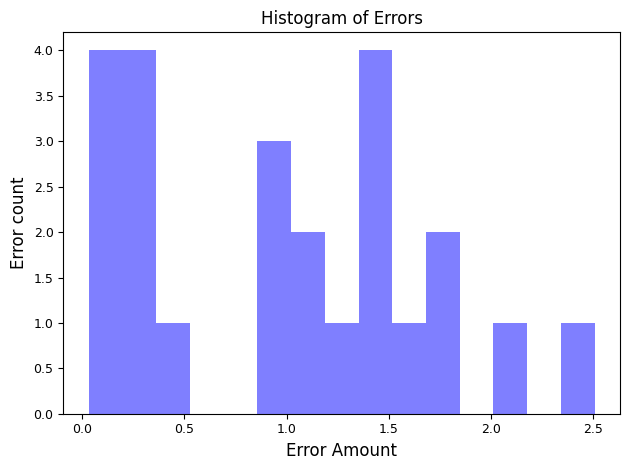

,y,ŷ,Δy
16,5.76,8.27,2.51
23,-8.05,-10.16,2.11
13,3.58,5.33,1.75
18,-4.35,-6.07,1.72
4,-7.50,-9.08,1.58
19,-4.14,-5.55,1.41
12,-5.72,-7.13,1.41
8,3.38,4.78,1.40
10,-5.67,-7.06,1.39
7,3.82,5.02,1.20


In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

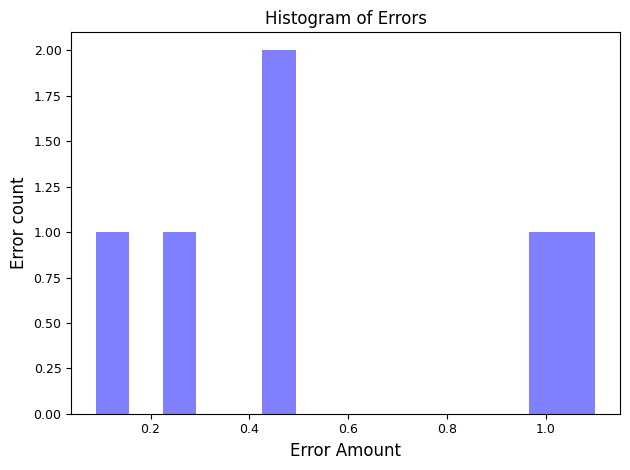

,y,ŷ,Δy
0,-5.91,-7.01,1.10
4,-2.61,-3.60,0.99
5,-2.31,-2.79,0.48
1,-0.21,-0.68,0.47
2,-0.05,0.24,0.29
3,0.20,0.11,0.09


In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')